In [ ]:
%load_ext autoreload
%autoreload 2
from FIFOv4 import FIFO
import matplotlib.pyplot as plt
import numpy as np
import math
from spcm import units
import spcm as spcm
import time as time
from time import sleep 
# import API classes into the current namespace
from pulsestreamer import PulseStreamer, Sequence  
import hdawg_driver_latest_v2 as awg
from sg396_driver_v1 import SG396
from pulser import PulseGenerator
from laser_driver import LaserControl
from thorlabs_laser_shutter_driver import LaserShutter

### Connect Instruments

In [2]:
# Digitizer 
FIFO = FIFO('dev/spcm0')

Successfully connected to the digitizer


In [3]:
# Pulse Streamer 

PSch_MW=2
PSch_Digitizer=1 

PS_chmap={'mw':PSch_MW,
          'digtrig':PSch_Digitizer}
ip = '10.135.70.193' 
ps = PulseGenerator(ip,PS_chmap)
INF = np.iinfo(np.int64).max


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 10.135.70.193
Pulse Streamer 8/2 firmware: v1.5.2
Client software: v1.7.0
Your client software is more up to date than the Pulse Streamer 8/2 firmware. We recommend updating the firmware of your Pulse Streamer 8/2.
For detailed information visit https://www.swabianinstruments.com/pulse-streamer-8-2/downloads/ or contact support@swabianinstruments.com


In [4]:
# AWB
awg = awg.HDAWG('dev8181', '127.0.0.1', 8004)

Trying to connect to dev8181 on interface USB
Connected to dev8181 via data server 127.0.0.1:8004 and interface USB


In [5]:
# Signal Generator 
sg = SG396('TCPIP::10.135.70.65::inst0::INSTR')

connected to SG396 [TCPIP::10.135.70.65::inst0::INSTR]


In [ ]:
laser = LaserControl('LAS-08166')
laser_shutter = LaserShutter('68800950')

### Configure Settings

In [7]:
awg_parameters = {
    "seq": "CW ODMR",
    "i_offset": -2*1e-3, #mV
    "q_offset": -4*1e-3, #mV
    "probe_length": 20*1e-6, #us
    "sideband_power": 150 * 1e-3, #mV
    "sideband_freqs": None, #MHz
    "iq_phases": [0,90],
    "num_pts": 40,
    "max_sideband" : 40*1e6,
    'runs':1000}

awg_parameters['sideband_freqs']=np.linspace(0,awg_parameters["max_sideband"],awg_parameters['num_pts'])
# print(awg_parameters)

In [8]:
dig_config = {'num_pts_in_exp': 2*awg_parameters['num_pts'], # MW ON + OFF subsequences
                      'runs': awg_parameters['runs'], # number of exp. iterations
                      'segment_size' :512*10 ,
                      'pretrig_size' : 32 ,
                      'readout_ch' : int(0),
                      'HF_INPUT_50OHM': 0}

In [9]:
# configure signal generator for NV drive
sg.set_frequency(2.34e9) # set carrier frequency
sg.set_rf_amplitude(100e-6) # set MW power
sg.set_mod_type(7) # quadrature amplitude modulation
sg.set_mod_subtype(1) # no constellation mapping
sg.set_mod_function('IQ', 5) # external modulation
sg.set_mod_toggle(1) # turn on modulation mode

### Assign Configuration 

In [10]:
awg.set_sequence(**{'seq': 'CW ODMR',
                    'i_offset': awg_parameters['i_offset'],
                    'q_offset': awg_parameters['q_offset'],
                    'probe_length': awg_parameters['probe_length'], 
                    'sideband_power': awg_parameters['sideband_power'],
                    'sideband_freqs': awg_parameters['sideband_freqs'], 
                    'iq_phases': awg_parameters['iq_phases'],
                    'num_pts': awg_parameters['num_pts']})
    

AWG COMPILE STATUS:  -1
AWG COMPILE STATUS again:  2
Warning during sequencer compilation:  Compilation started
Detected 1 devices with a total of 1 AWG cores.
Compiling source string
Warning (line: 7): waveform '__playWave_7_3' size 47999 is not aligned to 16 samples and will be zero-extended to 48000 samples
Warning (line: 11): waveform '__playWave_7_3' size 47999 is not aligned to 16 samples and will be zero-extended to 48000 samples
Warning (line: 15): waveform '__playWave_7_3' size 47999 is not aligned to 16 samples and will be zero-extended to 48000 samples
Warning (line: 19): waveform '__playWave_7_3' size 47999 is not aligned to 16 samples and will be zero-extended to 48000 samples
Warning (line: 23): waveform '__playWave_7_3' size 47999 is not aligned to 16 samples and will be zero-extended to 48000 samples
Warning (line: 27): waveform '__playWave_7_3' size 47999 is not aligned to 16 samples and will be zero-extended to 48000 samples
Warning (line: 31): waveform '__playWave_7_

In [11]:
FIFO.assign_param(settings_dict=dig_config)
FIFO.config()

SETTINGS: card timeout =  20 s
SETTINGS: # segments =  5120 Sa
SETTINGS: sampling freq =  0.5 GHz
SETTINGS: pretrig size =  32 Sa
SETTINGS: termination =  0
50 ohm impedance? 0


In [12]:
# laser.set_modulation_state('pulsed')
# laser.set_analog_control_mode('current')
# # laser.set_diode_current_realtime()

### Configure ODMR Pulse Sequence 

In [13]:
# probe_time = awg_parameters['probe_length']*1e9
# readout_time = 1000
# trig_time = 10

# def CW_ODMR(num_freqs):
        
#         '''
#         CW ODMR Sequence
#         Laser on for entire sequence. 
#         MW on for probe_time.
#         MW off for probe_time.
#         User sets how many voltage samples (num_clocks) to take during each MW on/off window.
#         '''
    
#         def SingleCW_ODMR():
#             clock_off1 = probe_time - 30*readout_time - trig_time
#             clock_off2 = 30*readout_time

#             iq_off = probe_time - trig_time

#             # define sequence structure for clock and MW I/Q channels
#             dig_clock_seq = [(clock_off1, 0), (trig_time, 1), (clock_off2, 0)]
#             dig_seq=dig_clock_seq+dig_clock_seq

#             mw_iq_seq_on = [(trig_time, 1), (iq_off, 0)]
#             mw_iq_seq_off = [(probe_time, 0)]
#             mw_seq=mw_iq_seq_on+mw_iq_seq_off

#             laser_clock_seq = [(probe_time, 1)]
#             laser_seq=laser_clock_seq+laser_clock_seq
            
#             return [mw_seq,dig_seq,laser_seq]
#         mw_seq_tot=[]
#         dig_seq_tot=[]
#         laser_seq_tot=[]
#         for i in range(num_freqs):
#             mw_seq_tot += SingleCW_ODMR()[0]
#             dig_seq_tot += SingleCW_ODMR()[1]
#             laser_seq_tot +=SingleCW_ODMR()[2]

#         return [mw_seq_tot,dig_seq_tot,laser_seq_tot]

In [14]:
probe_time = awg_parameters['probe_length']*1e9
readout_time = 1000
trig_time = 10

def CW_ODMR(num_freqs):
        
        '''
        CW ODMR Sequence
        Laser on for entire sequence. 
        MW on for probe_time.
        MW off for probe_time.
        User sets how many voltage samples (num_clocks) to take during each MW on/off window.
        '''
    
        def SingleCW_ODMR():
            # clock_off1 = probe_time - 10*readout_time - trig_time
            # clock_off2 = 10*readout_time
            clock_off1 = probe_time - trig_time
            # clock_off2 = 10*readout_time

            iq_off = probe_time - trig_time

            # define sequence structure for clock and MW I/Q channels
            dig_clock_seq = [ (trig_time, 1),(clock_off1, 0)] #, (clock_off2, 0)]
            dig_seq=dig_clock_seq+dig_clock_seq

            mw_iq_seq_on = [(trig_time, 1), (iq_off, 0)]
            mw_iq_seq_off = [(probe_time, 0)]
            mw_seq=mw_iq_seq_on+mw_iq_seq_off
            
            return [mw_seq,dig_seq]
        mw_seq_tot=[]
        dig_seq_tot=[]
        for i in range(num_freqs):
            mw_seq_tot += SingleCW_ODMR()[0]
            dig_seq_tot += SingleCW_ODMR()[1]

        return [mw_seq_tot,dig_seq_tot]

In [15]:
sequence=CW_ODMR(awg_parameters['num_pts'])

ps.setDigital("digtrig", sequence[1]) # digitizer trigger
ps.setTrigger
ps.setDigital("mw", sequence[0]) # MW IQ
ps.plotSeq(plot_all=False)

In [16]:
# STREAM 

In [17]:
# CONFIG 
# RF TOGGLE 
# START BUFF 
# ACQUIRE 


In [18]:
FIFO.config()
FIFO.start_buffer()


SETTINGS: card timeout =  20 s
SETTINGS: # segments =  5120 Sa
SETTINGS: sampling freq =  0.5 GHz
SETTINGS: pretrig size =  32 Sa
SETTINGS: termination =  0
50 ohm impedance? 0


In [ ]:
laser_shutter.open_shutter()
laser.set_modulation_state('cw')
laser.set_analog_control_mode('current')
laser.set_diode_current_realtime('100')
laser.laser_on()

In [19]:
sg.set_rf_toggle(1)
ps.stream(n_runs=INF)
DATA=FIFO.acquire()

(20000, 5120, 1)
termination setting: 0.0


In [20]:
FIFO.stop_card()
FIFO.reset()

Card stopped


In [21]:
# copy=[]
# for i in range(0,10):
#     FIFO.config()
#     sg.set_rf_toggle(1)
#     FIFO.start_buffer()
#     DATA=FIFO.acquire()
#     FIFO.stop_card()
#     FIFO.reset()
#     sg.set_rf_toggle(0)
#     copy.append(DATA)

# LASER OFF

In [ ]:
#STOP 
ps.reset()
sg.set_rf_toggle(0)
awg.set_disabled()
laser.laser_off()
laser_shutter.close_shutter()
FIFO.reset()

### Data Post Processing

In [23]:
np.shape(DATA)
import pandas as pd

In [24]:
reshaped_data = DATA.squeeze(axis=2)  # Reduces (20000, 5120, 1) to (20000, 5120)
data_to_save = pd.DataFrame(reshaped_data)

In [25]:
data_to_save.to_csv('ODMR_Contrast_Optimization.csv', index=False)  # Save without row indices


KeyboardInterrupt: 

In [ ]:
# DATA_mean=np.mean(np.mean(copy,axis=0),axis=1)

In [26]:
DATA_mean=np.mean(DATA,axis=1)
segments=(np.shape(DATA)[0])


In [27]:
sig=DATA_mean[::2]
bg=DATA_mean[1::2]


In [28]:
np.shape(sig)

(10000, 1)

In [29]:
sig_mean=np.zeros(awg_parameters['num_pts'])
bg_mean=np.zeros(awg_parameters['num_pts'])
for i in range(awg_parameters['runs']):
    for j in range(0,awg_parameters['num_pts']):
        sig_mean[j]+=np.mean(sig[j::awg_parameters['num_pts']])
        bg_mean[j]+=np.mean(bg[j::awg_parameters['num_pts']])

In [30]:
freq=np.flip(2.34e9-awg_parameters['sideband_freqs'])


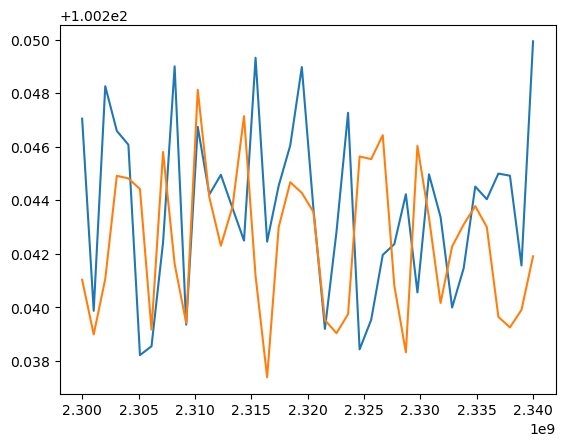

In [31]:
plt.plot(freq,sig_mean)
plt.plot(freq,bg_mean)


In [ ]:
# plt.plot(freq,sig_mean)
# plt.plot(freq,bg_mean)


In [152]:
len(DATA)

20000

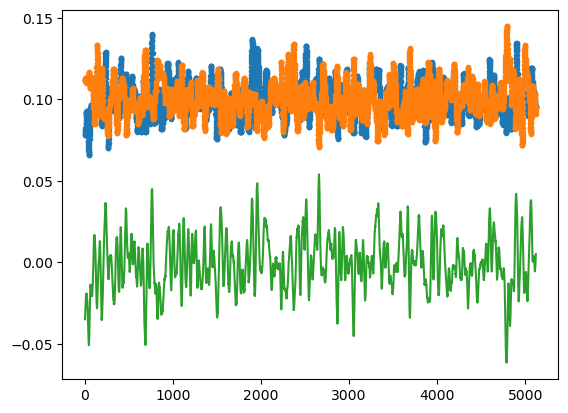

In [153]:
plt.plot(DATA[20],marker='.')
plt.plot(DATA[21],marker='.')
plt.plot(DATA[20]-DATA[21])

In [154]:
np.shape(DATA)

(20000, 5120, 1)

In [155]:
MW=DATA[::2]
BG=DATA[1::2]

In [156]:
MW_temp=np.mean(MW[::40],axis=0)

In [157]:
MW_20=np.mean(MW[20::40],axis=0)

In [158]:
MW_0=np.mean(MW[::40],axis=0)

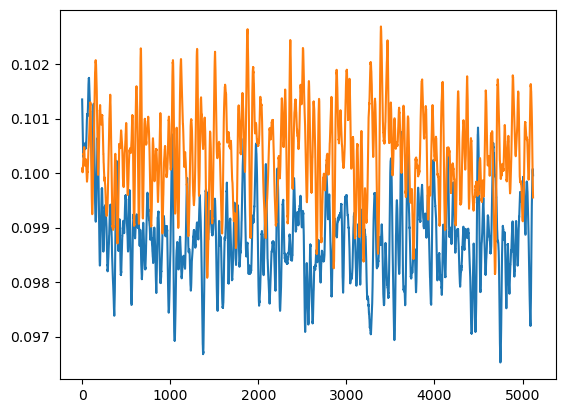

In [159]:
plt.plot(MW_20)
plt.plot(MW_0)
# plt.plot(MW_20-MW_0)

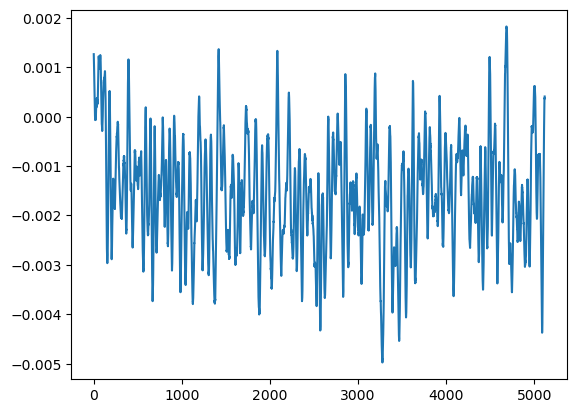

In [160]:
plt.plot(MW_20-MW_0)